### Resources

https://huggingface.co/docs/datasets/use_with_pytorch
https://huggingface.co/docs/datasets/v2.14.5/en/image_load

**Process images:**
- image processing: https://huggingface.co/docs/datasets/image_process#map
- transforms methods: https://pytorch.org/vision/stable/transforms.html#transforms
- HF general processing: https://huggingface.co/docs/datasets/process
- transforms v2 reference: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

**Test/Train split**
- use this: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.train_test_split

**Follow rest of tutorial**
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Building a Model Basics**
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import shutil
# import pathlib
# import PIL
# from PIL import Image




import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-9pcxr7ey because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format("torch")

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [4]:
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [5]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=100)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


torch.Size([3, 720, 1280])

In [6]:
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [7]:
# some of the images are greyscale, so we convert to RGB as well
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [8]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

In [9]:
# confirming 0-255 scaling of image tensors
sample_image = dataset[0]['image']

print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52])
Max value: 255
Min value: 0


In [10]:
# rescale tensors from 0-255 to 0-1
class ScaleTensor(object):
    def __call__(self, tensor):
        return tensor / 255.

# compose transformation function -> this is a more standard transform (according to pytorch documentation) to use later. Fitting my transform to the CIFAR tutorial model for now
# basic_transform = v2.Compose([
#     ScaleTensor(),
#     v2.RandomResizedCrop(size=(224, 224), antialias=True),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

basic_transform = v2.Compose([
    ScaleTensor(),
    v2.Resize(32),
    v2.CenterCrop(32),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=100)

### Examine Dataset/Model Compatibility Before Training

In [11]:
# are tensor values normalized to [-1, 1]?

correct_tensor_range = 0

for i, image in enumerate(dataset['image']):
    if image.min() < -1 or image.max() > 1:
        print(f"Image at index {i} has values outside expected range: min={image.min()}, max={image.max()}")
    else:
        correct_tensor_range += 1

print(correct_tensor_range)

1000


In [12]:
# are all tensors shape [3, 32, 32]?

correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 32, 32]):  # replace with expected shape
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000


In [13]:
# checking images and labels for consistency
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
def check_instrument(instr, ds):

    check = ds.filter(lambda x: x['label'] == instr)
    images = check['image'][0:32]
    labels = check['label'][0:32]

    # show images & labels
    imshow(torchvision.utils.make_grid(images))

    label_list = ''
    for i, lbl in enumerate(labels):
        label_list += label_values[labels[i].item()]
        if i % 8 == 7:
            label_list += '\n'
        else:
            label_list += ' | '
    print(label_list)

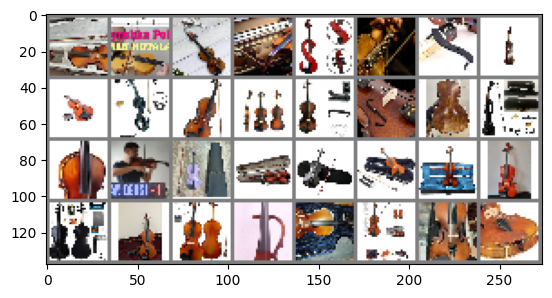

violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin



In [14]:
# should be all violins
check_instrument(5, dataset)

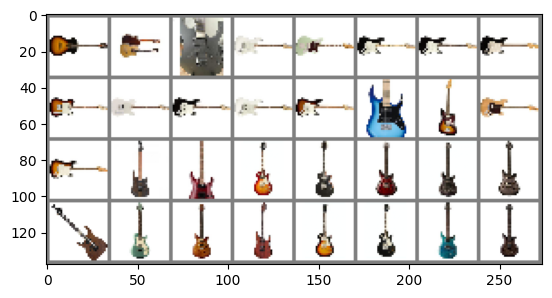

electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar



In [15]:
# should be all electric guitars
check_instrument(2, dataset)

### Dataloader Setup

In [16]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [17]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=2)

In [18]:
# check batch sizing (should be no output)
for batch in trainloader:
    if batch['image'].shape[0] != batch_size:
        print(f"Batch {i} has incorrect batch size: {images.shape[0]}")
    if batch['label'].shape[0] != batch_size:
        print(f"Batch {i} has mismatched images and labels")

In [19]:
# start with basic model from the tutorial

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [20]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
# for epoch in range(25):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs = data['image']
#         labels = data['label']
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 200 == 199:    # print every 200 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
#             running_loss = 0.0

# print('Finished Training')

### Saving and Testing the Model

In [22]:
# # save the locally-trained model in current working directory
# pwd = os.getcwd()
# filename = 'model v001.pth'
# path = os.path.join(pwd, filename)
# torch.save(net.state_dict(), path)

### Check Model Performance on Test Dataset

In [23]:
# in case we need to load model later
pwd = os.getcwd()
filename = 'model v001.pth'
path = os.path.join(pwd, filename)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

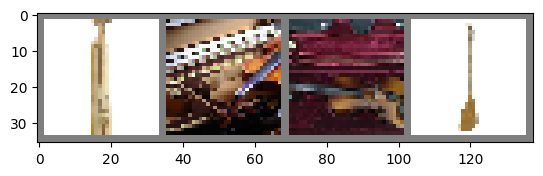

actual: kemence, violin, violin, baglama
predicted: kemence, kanun, harp, baglama


In [24]:
## testing a batch of images

# iterate through the dataset
dataiter = iter(testloader)
batch = next(dataiter)
images = batch['image']
labels = batch['label']

# print some test imagery and labels
imshow(torchvision.utils.make_grid(images))
actual = [label_values[labels[i].item()] for i in range(4)]
print('actual: '+', '.join(actual))

# test the model output on these images
outputs = net(images)
predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
print('predicted: '+', '.join(predicted))

In [25]:
# calculate accuracy
correct = 0
total = 0

for data in testloader:
    images = data['image']
    labels = data['label']

    prediction = net(images)
    predicted = torch.max(prediction, 1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'{correct} of {total} images categorized correctly: {100 * correct // total} %')

85 of 200 images categorized correctly: 42 %


In [26]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for data in testloader:
    images = data['image']
    labels = data['label']
    
    output = net(images)
    _, predicted = torch.max(output, 1)
    # predicted = torch.max(prediction, 1)[1]

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

In [27]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

In [28]:
# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

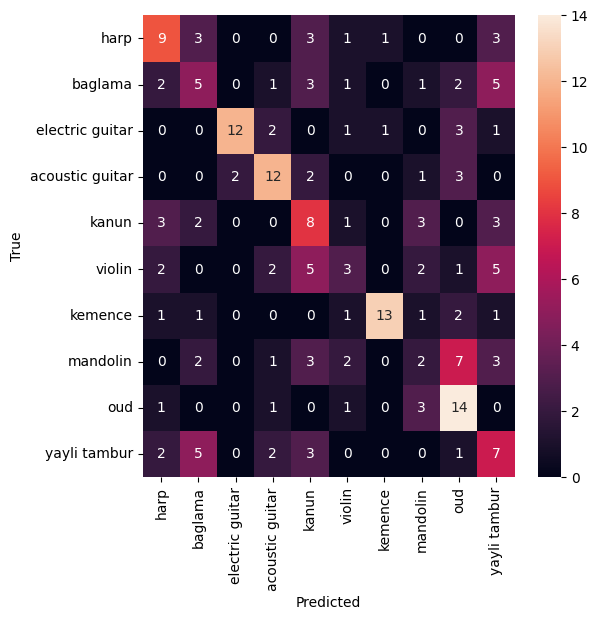

In [29]:
# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

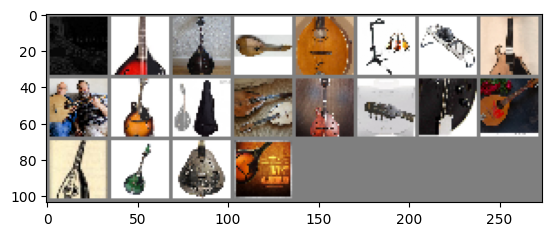

mandolin | mandolin | mandolin | mandolin | mandolin | mandolin | mandolin | mandolin
mandolin | mandolin | mandolin | mandolin | mandolin | mandolin | mandolin | mandolin
mandolin | mandolin | mandolin | mandolin | 


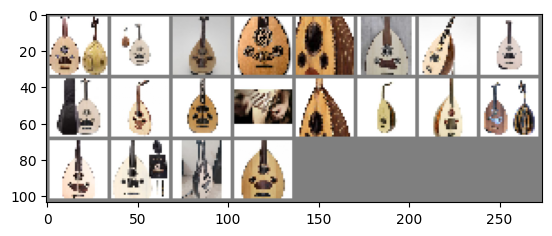

oud | oud | oud | oud | oud | oud | oud | oud
oud | oud | oud | oud | oud | oud | oud | oud
oud | oud | oud | oud | 


In [30]:
# compare images from highest and lowest performing instruments (mandolin/oud)
check_instrument(7, dataset['test'])
check_instrument(8, dataset['test'])

In [32]:
# examine images that were predicted correctly and incorrectly
def add_predictions(example, i):
    example['predicted_label'] = pred_label[i]
    return example

test_results = dataset['test'].map(add_predictions, with_indices=True)

test_pass = test_results.filter(lambda x: x['label'] == x['predicted_label'])
test_fail = test_results.filter(lambda x: x['label'] != x['predicted_label'])

In [33]:
def check_results(ds, limit):

    images = ds['image'][0:limit]
    labels = ds['label'][0:limit]
    predict = ds['predicted_label'][0:limit]

    label_list = ''
    for i, lbl in enumerate(labels):
        true = label_values[labels[i].item()]
        pred = label_values[predict[i].item()]
        print(f'actual: {true} | predicted: {pred}')
        plt.figure(figsize=(1, 1))
        imshow(images[i])

actual: violin | predicted: kanun


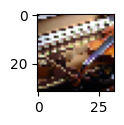

actual: violin | predicted: harp


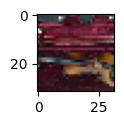

actual: yayli tambur | predicted: harp


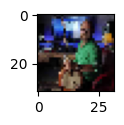

actual: oud | predicted: mandolin


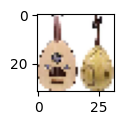

actual: baglama | predicted: oud


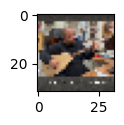

actual: violin | predicted: yayli tambur


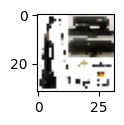

actual: baglama | predicted: oud


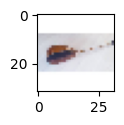

actual: yayli tambur | predicted: acoustic guitar


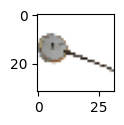

actual: violin | predicted: yayli tambur


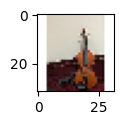

actual: yayli tambur | predicted: kanun


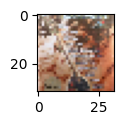

actual: acoustic guitar | predicted: oud


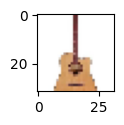

actual: kanun | predicted: mandolin


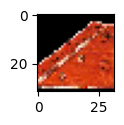

actual: yayli tambur | predicted: kanun


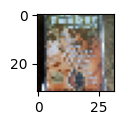

actual: kemence | predicted: yayli tambur


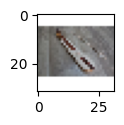

actual: kemence | predicted: oud


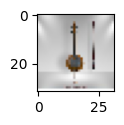

actual: violin | predicted: acoustic guitar


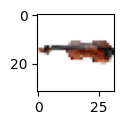

actual: violin | predicted: kanun


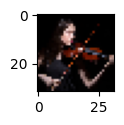

actual: baglama | predicted: violin


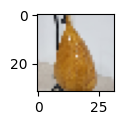

actual: yayli tambur | predicted: oud


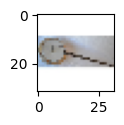

actual: mandolin | predicted: yayli tambur


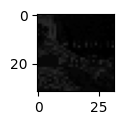

In [34]:
check_results(test_fail, 20)